In [1]:
%reset -f

In [1]:
%pwd

'C:\\Users\\fullh'

In [19]:
%%javascript
document.addEventListener('keydown', function(e) {
  if (e.key === 'F12') {
    e.preventDefault()
    if (document.fullscreenElement) {
      document.exitFullscreen();
    } else {
      document.documentElement.requestFullscreen();
    }
  }
});


<IPython.core.display.Javascript object>

### Imports and inputs

In [2]:
%reset -f
import pandas as pd
import arcpy
import os
from IPython.display import display

baseDIR = r'C:\Users\fullh\Documents\ArcGIS\Projects'
myProject = 'MyProject'
projDIR = r'{}\{}'.format(baseDIR, myProject)
dataDIR = r'{}\{}\Data'.format(baseDIR, myProject)
gdbDIR = r'{}\{}\{}.gdb'.format(baseDIR, myProject, myProject)

arcpy.env.overwriteOutput = True

if os.path.exists(os.path.join(projDIR, 'schema.ini')):
  os.remove(os.path.join(projDIR, 'schema.ini'))

for f in os.listdir(projDIR):
  if 'RasterToNetCD' in f:
    os.remove(os.path.join(projDIR, f))

arcpy.management.Delete(os.path.join(gdbDIR, 'clip_raster'))
arcpy.management.Delete(os.path.join(gdbDIR, 'NoData_Composite'))
arcpy.management.Delete(os.path.join(gdbDIR, 'Filled_Composite'))
arcpy.management.Delete(os.path.join(gdbDIR, 'FloatIsoCluster'))
arcpy.management.Delete(os.path.join(gdbDIR, 'RasterToPoint'))
arcpy.management.Delete(os.path.join(gdbDIR, 'ForbsandGrass'))
arcpy.management.Delete(os.path.join(gdbDIR, 'ForbsandGrassN'))
arcpy.management.Delete(os.path.join(gdbDIR, 'us_eco_l3'))
arcpy.management.Delete(os.path.join(gdbDIR, 'us_eco_l4'))

data_files = os.listdir(dataDIR)

input_string = ';'.join(data_files)
input_list = input_string.split(';')

print('ArcPy imported')

ArcPy imported


### SHAPEFILES: clip_area, us_eco_l3, us_eco_l4. RASTERS: l3 and l4 polygons, latitude.

In [3]:

arcpy.env.workspace = dataDIR

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['CCSM4_1974_2013_consec.tif'],
    input_names=['raster'],
    expression='raster >= 0'
  )
output_raster.save(os.path.join(gdbDIR, 'clip_raster'))

arcpy.env.workspace = gdbDIR

with arcpy.EnvManager(outputZFlag='Disabled', outputMFlag='Disabled'):
  arcpy.conversion.RasterToPolygon(
    in_raster='clip_raster',
    out_polygon_features=os.path.join(gdbDIR, 'clip_shape'),
    simplify='SIMPLIFY',
    raster_field='Value',
    create_multipart_features='SINGLE_OUTER_PART',
    max_vertices_per_feature=None
  )

arcpy.management.Project(
  in_dataset=os.path.join(projDIR, 'us_eco_l4', 'us_eco_l4_no_st.shp'),
  out_dataset='us_eco_l4',
  out_coor_system='GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]',
  transform_method='WGS_1984_(ITRF00)_To_NAD_1983',
  in_coor_system='PROJCS["USA_Contiguous_Albers_Equal_Area_Conic_USGS_version",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-96.0],PARAMETER["Standard_Parallel_1",29.5],PARAMETER["Standard_Parallel_2",45.5],PARAMETER["Latitude_Of_Origin",23.0],UNIT["Meter",1.0]]',
  preserve_shape='NO_PRESERVE_SHAPE',
  max_deviation=None,
  vertical='NO_VERTICAL'
)

arcpy.management.Project(
  in_dataset=os.path.join(projDIR, 'us_eco_l3', 'us_eco_l3.shp'),
  out_dataset='us_eco_l3',
  out_coor_system='GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]',
  transform_method='WGS_1984_(ITRF00)_To_NAD_1983',
  in_coor_system='PROJCS["USA_Contiguous_Albers_Equal_Area_Conic_USGS_version",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-96.0],PARAMETER["Standard_Parallel_1",29.5],PARAMETER["Standard_Parallel_2",45.5],PARAMETER["Latitude_Of_Origin",23.0],UNIT["Meter",1.0]]',
  preserve_shape='NO_PRESERVE_SHAPE',
  max_deviation=None,
  vertical='NO_VERTICAL'
)

arcpy.analysis.Clip(
  in_features='us_eco_l4',
  clip_features='clip_shape',
  out_feature_class='us_eco_l4_clip',
  cluster_tolerance=None
)

arcpy.analysis.Clip(
  in_features='us_eco_l3',
  clip_features='clip_shape',
  out_feature_class='us_eco_l3_clip',
  cluster_tolerance=None
)

arcpy.conversion.PolygonToRaster(
  in_features='us_eco_l4_clip',
  value_field='US_L4CODE',
  out_rasterdataset='us_eco_l4_raster',
  cell_assignment='CELL_CENTER',
  priority_field='NONE',
  cellsize='clip_raster',
  build_rat='BUILD'
)

arcpy.conversion.PolygonToRaster(
  in_features='us_eco_l3_clip',
  value_field='US_L3CODE',
  out_rasterdataset='us_eco_l3_raster',
  cell_assignment='CELL_CENTER',
  priority_field='NONE',
  cellsize='clip_raster',
  build_rat='BUILD'
)

arcpy.conversion.RasterToPoint(
  in_raster='us_eco_l3_raster',
  out_point_features='RasterToPoint',
  raster_field='Value'
)

arcpy.management.AddXY(
  in_features='RasterToPoint'
)

arcpy.conversion.PointToRaster(
  in_features='RasterToPoint',
  value_field='POINT_Y',
  out_rasterdataset='Latitude',
  cell_assignment='MOST_FREQUENT',
  priority_field='NONE',
  cellsize='clip_raster',
  build_rat='DO_NOT_BUILD'
)


<Result 'C:\\Users\\fullh\\Documents\\ArcGIS\\Projects\\MyProject\\MyProject.gdb\\Latitude'>

### Make Extract_Composite multi-band raster

In [19]:

input_list = uncorr_input_list
input_string = uncorr_input_string

input_string = input_string.replace('.tif', "")

arcpy.env.workspace = gdbDIR

for f in input_list:

  raster = arcpy.Raster(os.path.join(dataDIR, f))
    
  with arcpy.EnvManager(scratchWorkspace=gdbDIR):
    output_raster = arcpy.sa.ExtractByMask(
      in_raster=raster,
      in_mask_data='clip_shape',
      extraction_area='INSIDE',
      analysis_extent='-120.004083333317 31.3333333333001 -102.995916734683 42.004083290617 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]'
    )
      
  #Don't save if Normalizing
  #output_raster.save(f[:-4])

  ##########
  ##Normalize Z-score
  ###

  # arcpy.management.CalculateStatistics(output_raster)
  # mean_value = arcpy.Raster(output_raster).mean
  # sdev_value = arcpy.Raster(output_raster).standardDeviation
  # print('mean:', mean_value)
  # print('sdev:', sdev_value)
  # with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  #   out_raster = arcpy.ia.RasterCalculator(
  #     rasters=[output_raster],
  #     input_names=['raster'],
  #     expression='(raster - {})/({})'.format(mean_value, sdev_value)
  #   )

  # out_raster.save(f[:-4])

  ##########
  ##Normalize 0-1
  ###

  arcpy.management.CalculateStatistics(output_raster)
  min_value = arcpy.Raster(output_raster).minimum
  max_value = arcpy.Raster(output_raster).maximum
  with arcpy.EnvManager(scratchWorkspace=gdbDIR):
    out_raster = arcpy.ia.RasterCalculator(
      rasters=[output_raster],
      input_names=['raster'],
      expression='(raster - {})/({} - {})'.format(min_value, max_value, min_value)
    )

  out_raster.save(f[:-4])

with arcpy.EnvManager(scratchWorkspace=gdbDIR, extent='MAXOF'):
  arcpy.management.CompositeBands(
    in_rasters=input_string,
    out_raster='CompositeBands'
  )

for f in input_list:
  arcpy.management.Delete(f[:-4])

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['CompositeBands'],
    input_names=['raster'],
    expression='raster * 1'
  )
output_raster.save('NoData_Composite')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=['NoData_Composite'],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )
output_raster.save('Filled_Composite')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.sa.ExtractByMask(
    in_raster='Filled_Composite',
    in_mask_data='clip_shape',
    extraction_area='INSIDE',
    analysis_extent='-120.004083333317 31.3333333333001 -102.995916734683 42.004083290617 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]'
  )
output_raster.save('Extract_Composite')

arcpy.CopyRaster_management('Extract_Composite', os.path.join(projDIR, 'Extract_Composite.tif'))

print('DONE')


DONE


### Run principle component tool to get information from output text file.

In [20]:

arcpy.env.workspace = gdbDIR

with arcpy.EnvManager(scratchWorkspace=projDIR):
  out_multiband_raster = arcpy.sa.PrincipalComponents(
    in_raster_bands='Extract_Composite',
    number_components=5,
    out_data_file='pca_info.txt'
  )
out_multiband_raster.save(os.path.join(gdbDIR, 'Princip_Composite'))

# with arcpy.EnvManager(scratchWorkspace=gdbDIR):
#   output_raster = arcpy.ia.RasterCalculator(
#     rasters=['Princip_Composite'],
#     input_names=['raster'],
#     expression='Con(IsNull(raster),1,raster)'
#   )
# output_raster.save(os.path.join(gdbDIR, 'Filled_Composite'))

# with arcpy.EnvManager(scratchWorkspace=gdbDIR):
#   output_raster = arcpy.sa.ExtractByMask(
#     in_raster='Filled_Composite',
#     in_mask_data='clip_shape',
#     extraction_area='INSIDE',
#     analysis_extent='-120.004083333317 31.3333333333001 -102.995916734683 42.004083290617 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]'
#   )
# output_raster.save(os.path.join(gdbDIR, 'Princip_Composite'))

print('DONE')


DONE


### Print correlation matrix

In [11]:

#input_list = uncorr_input_list

vif_cutoff = 3

pca_info_path = 'pca_info.txt'


with open(os.path.join(projDIR, pca_info_path)) as f:
  lines = f.readlines()

for i, line in enumerate(lines):
  if 'CORRELATION MATRIX' in line:
    hdr_line_idx = i
    for j, l in enumerate(lines[hdr_line_idx:]):
      if '#  ========' in l:
        ftr_line_idx = hdr_line_idx + j
        break
    break

start_idx = hdr_line_idx + 4
end_idx = ftr_line_idx - 1

corr_m_lines = lines[start_idx:end_idx + 1]

corr_data = []
for l in corr_m_lines:
  row = l.split()
  corr_data.append([float(x) for x in row[1:]])

corr_df = pd.DataFrame(corr_data)

def vif_fn(x):
  if x != 1:
    vif = (1)/(1 - x**2)
  else:
    vif = 0
  return vif

vif_df = corr_df.map(vif_fn)

high_value_mask = vif_df >= vif_cutoff
stacked_mask = high_value_mask.stack()
result = stacked_mask[stacked_mask]

matrix_index_col_list = []
for (index, col), _ in result.items():
  matrix_index_col_list.append([index, col])

index_col_list = []
for l in matrix_index_col_list:
  if l not in index_col_list and l.reverse() not in index_col_list:
    index_col_list.append(l)

print('VIF FACTORS >={}:'.format(vif_cutoff))  
for index, col in index_col_list:
  print(f"Index: {index}, Column: {col}, Value: {vif_df.loc[index, col]}")
  print(input_list[index], input_list[col])


VIF FACTORS >=3:


### Remove multicolinearity from inputs with VIF > 5 EXCEPT FOR DEM_Elev.tif

In [17]:

removal_choices = ['pmomx_1974_2013.tif', 'CCSM4_1974_2013_pet.tif', 'POL_theta_s.tif', 'POL_theta_r.tif', 'RAP_afg.tif', 'RAP_pfg.tif', 'RAP_tre.tif', 'RAP_shr.tif', 'tmean_1974_2013.tif']

uncorr_input_list = []
for l in input_list:
  if l not in removal_choices:
    uncorr_input_list.append(l)

uncorr_input_string = ';'.join(uncorr_input_list)

var_labels = [s[:-4] for s in input_list]
df = pd.DataFrame(data=var_labels, index=list(range(1, len(var_labels)+1)))
print('All Variables:')
display(df)

var_labels = [s[:-4] for s in uncorr_input_list]
df = pd.DataFrame(data=var_labels, index=list(range(1, len(var_labels)+1)))
print('Uncorrelated Variables:')
display(df)

varidx_varlbl_key = df.to_dict()[0]
print(varidx_varlbl_key)


All Variables:


,0
1,accm_1974_2013
2,CCSM4_1974_2013_ero
3,CCSM4_1974_2013_ndays
4,DEM_Elev
5,DEM_Slope
6,POL_bd
7,POL_ksat
8,POL_om
9,POL_ph
10,POL_sand


Uncorrelated Variables:


,0
1,accm_1974_2013
2,CCSM4_1974_2013_ero
3,CCSM4_1974_2013_ndays
4,DEM_Elev
5,DEM_Slope
6,POL_bd
7,POL_ksat
8,POL_om
9,POL_ph
10,POL_sand


{1: 'accm_1974_2013', 2: 'CCSM4_1974_2013_ero', 3: 'CCSM4_1974_2013_ndays', 4: 'DEM_Elev', 5: 'DEM_Slope', 6: 'POL_bd', 7: 'POL_ksat', 8: 'POL_om', 9: 'POL_ph', 10: 'POL_sand', 11: 'RAP_afgNPP', 12: 'RAP_bgr', 13: 'RAP_ltr', 14: 'RAP_pfgNPP', 15: 'RAP_shrNPP', 16: 'RAP_treNPP', 17: 'tmomn_1974_2013'}


### Remove multicolinearity from inputs with VIF > 3 EXCEPT FOR DEM_Elev.tif

In [3]:
removal_choices = ['tmomx_1974_2013.tif', 'pmomx_1974_2013.tif', 'pmomn_1974_2013.tif', 'CCSM4_1974_2013_swe.tif', 'CCSM4_1974_2013_consec.tif', 'CCSM4_1974_2013_pet.tif', 'POL_theta_s.tif', 'POL_theta_r.tif', 'POL_clay.tif', 'POL_silt.tif', 'RAP_afg.tif', 'RAP_pfg.tif', 'RAP_tre.tif', 'RAP_shr.tif', 'tmean_1974_2013.tif']

uncorr_input_list = []
for l in input_list:
  if l not in removal_choices:
    uncorr_input_list.append(l)

uncorr_input_string = ';'.join(uncorr_input_list)

var_labels = [s[:-4] for s in input_list]
df = pd.DataFrame(data=var_labels, index=list(range(1, len(var_labels)+1)))
print('All Variables:')
display(df)

var_labels = [s[:-4] for s in uncorr_input_list]
df = pd.DataFrame(data=var_labels, index=list(range(1, len(var_labels)+1)))
print('Uncorrelated Variables:')
display(df)

varidx_varlbl_key = df.to_dict()[0]
print(varidx_varlbl_key)


All Variables:


,0
1,accm_1974_2013
2,CCSM4_1974_2013_consec
3,CCSM4_1974_2013_ero
4,CCSM4_1974_2013_ndays
5,CCSM4_1974_2013_pet
6,CCSM4_1974_2013_swe
7,DEM_Elev
8,DEM_Slope
9,pmomn_1974_2013
10,pmomx_1974_2013


Uncorrelated Variables:


,0
1,accm_1974_2013
2,CCSM4_1974_2013_ero
3,CCSM4_1974_2013_ndays
4,DEM_Elev
5,DEM_Slope
6,POL_bd
7,POL_ksat
8,POL_om
9,POL_ph
10,POL_sand


{1: 'accm_1974_2013', 2: 'CCSM4_1974_2013_ero', 3: 'CCSM4_1974_2013_ndays', 4: 'DEM_Elev', 5: 'DEM_Slope', 6: 'POL_bd', 7: 'POL_ksat', 8: 'POL_om', 9: 'POL_ph', 10: 'POL_sand', 11: 'RAP_afgNPP', 12: 'RAP_bgr', 13: 'RAP_ltr', 14: 'RAP_pfgNPP', 15: 'RAP_shrNPP', 16: 'RAP_treNPP', 17: 'tmomn_1974_2013'}


### Iso Cluster using composite as input.

In [48]:

arcpy.env.workspace = gdbDIR

with arcpy.EnvManager(scratchWorkspace=os.path.join(gdbDIR)):
  output_classified_raster = arcpy.sa.IsoClusterUnsupervisedClassification(
    in_raster_bands='Extract_Composite',
    Number_of_classes=15,
    Minimum_class_size=250,
    Sample_interval=5,
    out_signature_file=os.path.join(projDIR, 'iso_signature.gsg')
  )
output_classified_raster.save('FloatIsoCluster')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  out_raster = arcpy.ia.Int(
    in_raster_or_constant='FloatIsoCluster'
  )
out_raster.save('IsoCluster')

arcpy.CopyRaster_management('IsoCluster', os.path.join(projDIR, 'IsoCluster.tif'))

print('DONE')


DONE


### Iso Cluster using PCA as input and multidimensional raster.

In [27]:

import random
threedigits = [str(x) for x in random.sample(range(0, 10), 3)]

arcpy.env.workspace = gdbDIR

arcpy.md.RasterToNetCDF(
  in_raster='Extract_Composite',
  out_netCDF_file=os.path.join(projDIR, 'RasterToNetCD' + ''.join(threedigits) + '.nc'),
  variable='Extract_Composite',
  variable_units='',
  x_dimension='lon',
  y_dimension='lat',
  band_dimension='band',
  fields_to_dimensions=None,
  compression_level=0
)

arcpy.md.MakeMultidimensionalRasterLayer(
  in_multidimensional_raster=os.path.join(projDIR, 'RasterToNetCD' + ''.join(threedigits) + '.nc'),
  out_multidimensional_raster_layer='MultidimRasterLyr',
  variables='Extract_Composite',
  dimension_def='ALL',
  dimension_ranges=None,
  dimension_values=None,
  dimension='',
  start_of_first_iteration='',
  end_of_first_iteration='',
  iteration_step=None,
  iteration_unit='',
  template='-120.00833328533 31.3333333207995 -102.991666625469 42.00833331653 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]',
  dimensionless='DIMENSIONS',
  spatial_reference=None
)

arcpy.ia.MultidimensionalPrincipalComponents(
  in_multidimensional_raster='MultidimRasterLyr',
  mode='DIMENSION_REDUCTION',
  dimension='band',
  out_pc=os.path.join(projDIR, 'MultidimRasterLyr_d_pc.crf'),
  out_loadings=os.path.join(projDIR, 'MultidimRasterLyr_d_loading.csv'),
  out_eigenvalues=os.path.join(gdbDIR, 'eigenvalues'),
  variable='Extract_Composite',
  number_of_pc='99%'
)

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  Output_classified_raster = arcpy.sa.IsoClusterUnsupervisedClassification(
    in_raster_bands=os.path.join(projDIR, 'MultidimRasterLyr_d_pc.crf'),
    Number_of_classes=15,
    Minimum_class_size=250,
    Sample_interval=5,
    out_signature_file=os.path.join(projDIR, 'iso_signature.gsg')
  )
Output_classified_raster.save(os.path.join(gdbDIR, 'IsoCluster'))

arcpy.CopyRaster_management('IsoCluster', os.path.join(projDIR, 'IsoCluster.tif'))

# with arcpy.EnvManager(scratchWorkspace=gdbDIR):
#   output_raster = arcpy.ia.RasterCalculator(
#     rasters=['FloatIsoCluster'],
#     input_names=['raster'],
#     expression='raster * 1'
#   )
# output_raster.save('NoData_Composite')

# with arcpy.EnvManager(scratchWorkspace=gdbDIR):
#   output_raster = arcpy.ia.RasterCalculator(
#     rasters=['NoData_Composite'],
#     input_names=['raster'],
#     expression='Con(IsNull(raster),1,raster)'
#   )
# output_raster.save('Filled_Composite')

# with arcpy.EnvManager(scratchWorkspace=gdbDIR):
#   output_raster = arcpy.ia.Int(
#     in_raster_or_constant='Filled_Composite'
#   )
# output_raster.save('clip_raster')

# with arcpy.EnvManager(scratchWorkspace=gdbDIR):
#   output_raster = arcpy.sa.ExtractByMask(
#     in_raster='clip_raster',
#     in_mask_data='clip_shape',
#     extraction_area='INSIDE',
#     analysis_extent='-120.004083333317 31.3333333333001 -102.995916734683 42.004083290617 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]'
#   )
# output_raster.save('IsoCluster')

# arcpy.CopyRaster_management('IsoCluster', os.path.join(projDIR, 'IsoCluster.tif'))

print('DONE')


DONE


### Zonal stats table export

In [28]:

import os

if not os.path.exists(os.path.join(projDIR, 'Zonal')):
  os.makedirs(os.path.join(projDIR, 'Zonal'))

arcpy.env.workspace = gdbDIR

arcpy.sa.ZonalHistogram(
  in_zone_data='us_eco_l3_clip',
  zone_field='US_L3CODE',
  in_value_raster='IsoCluster',
  out_table='Zonal_eco3',
  out_graph='',
  zones_as_rows='ZONES_AS_FIELDS'
)

arcpy.conversion.ExportTable(
  in_table='Zonal_eco3',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_eco3.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_eco3')

arcpy.sa.ZonalHistogram(
  in_zone_data='us_eco_l4_clip',
  zone_field='US_L4CODE',
  in_value_raster='IsoCluster',
  out_table='Zonal_eco4',
  out_graph='',
  zones_as_rows='ZONES_AS_FIELDS'
)

arcpy.conversion.ExportTable(
  in_table='Zonal_eco4',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_eco4.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_eco4')

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'DEM_Elev.tif'),
  out_table='Zonal_elev',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_elev',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_elev.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_elev')

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'DEM_Slope.tif'),
  out_table='Zonal_slpe',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_slpe',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_slpe.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_slpe')

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'accm_1974_2013.tif'),
  out_table='Zonal_accm',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_accm',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_accm.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_accm')

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'CCSM4_1974_2013_ndays.tif'),
  out_table='Zonal_nday',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_nday',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_nday.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_nday')

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'CCSM4_1974_2013_ero.tif'),
  out_table='Zonal_eroR',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_eroR',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_eroR.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_eroR')

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=os.path.join(dataDIR, 'tmean_1974_2013.tif'),
  out_table='Zonal_tavg',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_tavg',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_tavg.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_tavg')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[os.path.join(dataDIR, 'RAP_bgr.tif')],
    input_names=['raster'],
    expression='raster * 1'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[output_raster],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=output_raster,
  out_table='Zonal_bare',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_bare',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_bare.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_bare')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[os.path.join(dataDIR, 'RAP_ltr.tif')],
    input_names=['raster'],
    expression='raster * 1'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[output_raster],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=output_raster,
  out_table='Zonal_litr',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_litr',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_litr.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_litr')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[os.path.join(dataDIR, 'RAP_treNPP.tif')],
    input_names=['raster'],
    expression='raster * 1'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[output_raster],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=output_raster,
  out_table='Zonal_tree',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_tree',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_tree.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)
arcpy.management.Delete('Zonal_tree')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[os.path.join(dataDIR, 'RAP_pfgNPP.tif')],
    input_names=['raster'],
    expression='raster * 1'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[output_raster],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=output_raster,
  out_table='Zonal_pfgN',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_pfgN',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_pfgN.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_pfgN')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[os.path.join(dataDIR, 'RAP_shrNPP.tif')],
    input_names=['raster'],
    expression='raster * 1'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[output_raster],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=output_raster,
  out_table='Zonal_shrN',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_shrN',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_shrN.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_shrN')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[os.path.join(dataDIR, 'POL_om.tif')],
    input_names=['raster'],
    expression='raster * 1'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[output_raster],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=output_raster,
  out_table='Zonal_orgm',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_orgm',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_orgm.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_orgm')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[os.path.join(dataDIR, 'POL_clay.tif')],
    input_names=['raster'],
    expression='raster * 1'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[output_raster],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=output_raster,
  out_table='Zonal_clay',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_clay',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_clay.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_clay')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[os.path.join(dataDIR, 'POL_bd.tif')],
    input_names=['raster'],
    expression='raster * 1'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[output_raster],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=output_raster,
  out_table='Zonal_bulk',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_bulk',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_bulk.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_bulk')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[os.path.join(dataDIR, 'POL_ph.tif')],
    input_names=['raster'],
    expression='raster * 1'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[output_raster],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=output_raster,
  out_table='Zonal_pphh',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_pphh',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_pphh.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_pphh')

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster='Latitude',
  out_table='Zonal_ylat',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_ylat',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_ylat.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_ylat')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[os.path.join(dataDIR, 'RAP_pfg.tif'), os.path.join(dataDIR, 'RAP_afg.tif')],
    input_names=['pfg', 'afg'],
    expression='pfg + afg'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[output_raster],
    input_names=['raster'],
    expression='raster * 1'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[output_raster],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=output_raster,
  out_table='Zonal_gras',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_gras',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_gras.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_gras')

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[os.path.join(dataDIR, 'RAP_pfgNPP.tif'), os.path.join(dataDIR, 'RAP_afgNPP.tif')],
    input_names=['pfg', 'afg'],
    expression='pfg + afg'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[output_raster],
    input_names=['raster'],
    expression='raster * 1'
  )

with arcpy.EnvManager(scratchWorkspace=gdbDIR):
  output_raster = arcpy.ia.RasterCalculator(
    rasters=[output_raster],
    input_names=['raster'],
    expression='Con(IsNull(raster),1,raster)'
  )

arcpy.ia.ZonalStatisticsAsTable(
  in_zone_data='IsoCluster',
  zone_field='Value',
  in_value_raster=output_raster,
  out_table='Zonal_graN',
  ignore_nodata='DATA',
  statistics_type='ALL',
  process_as_multidimensional='CURRENT_SLICE',
  percentile_values=[90],
  percentile_interpolation_type='AUTO_DETECT',
  circular_calculation='ARITHMETIC',
  circular_wrap_value=360,
  out_join_layer=None
)

arcpy.conversion.ExportTable(
  in_table='Zonal_graN',
  out_table=os.path.join(projDIR, 'Zonal', 'Zonal_graN.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.management.Delete('Zonal_graN')


<Result 'true'>

### Determine temperature class order and setup for correlation scatterplots

In [17]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

files = [f for f in os.listdir(os.path.join(projDIR, 'Zonal')) if 'Zonal' in f and f[-4:] == '.csv' and 'eco3' not in f and 'eco4' not in f]
labels = [f.split('_')[1][:-4] for f in files]

df = pd.DataFrame()
for i, f in enumerate(files):
  idf = pd.read_csv(os.path.join(projDIR, 'Zonal', f))
  df[labels[i]] = idf['MEAN']

df['orgm'] = df['orgm'].apply(lambda x: 10**x)

#TEMPERATURE-BASED CLASS ORDER
temp_order_df = df.sort_values(by='tavg', ascending=False)
temp_order_df.index.name = 'arc_id'
df = temp_order_df.reset_index()

arcid_list = [x+1 for x in df['arc_id'].tolist()]
class_list = list(range(1, len(arcid_list)+1))
arc_temporder_key = dict(zip(class_list, arcid_list))
print(arc_temporder_key)

colors = ['#BDBEBE', '#F4714F', '#FF611B', '#FBAF1C', '#F8E019', '#CCFE29', '#91FE28', '#00FE24', '#18F2FE', '#3AC2FD', '#5E79FD', '#6E12FC', '#E21DFD', '#FF18A9', '#FF2B18']

arc_colors = []
for key, value in arc_temporder_key.items():
  arc_colors.append(colors[value-1])

display(pd.DataFrame(data=arc_colors))

def plot_fn():
  z = np.polyfit(x, y, deg=1)
  p = np.poly1d(z)
  ax.margins(0.25, 0.25)
  ax.plot(x, p(x), color='black', linestyle=':', linewidth=1, zorder=-999)
  ax.scatter(x, y, s=50, c=colors, edgecolor='k')
  ymin, ymax = ax.get_ylim()[0], ax.get_ylim()[1]
  xmin, xmax = ax.get_xlim()[0], ax.get_xlim()[1]
  for i in range(1, len(x)+1):
    ax.text(x[i-1] - 0.025*(xmax - xmin), y[i-1] + 0.025*(ymax - ymin), i, fontsize=9)

print('DONE')

display(df)


{1: 1, 2: 5, 3: 8, 4: 9, 5: 15, 6: 12, 7: 2, 8: 3, 9: 6, 10: 4, 11: 7, 12: 11, 13: 14, 14: 10, 15: 13}


,0
0,#BDBEBE
1,#F8E019
2,#00FE24
3,#18F2FE
4,#FF2B18
5,#6E12FC
6,#F4714F
7,#FF611B
8,#CCFE29
9,#FBAF1C


DONE


,arc_id,accm,bare,bulk,clay,elev,eroR,graN,gras,litr,nday,orgm,pfgN,pphh,shrN,slpe,tavg,tree,ylat
0,0,157.171111,43.849876,1.429126,12.970602,507.128892,685.193358,190.808397,11.160818,9.360057,25.907643,0.182260,28.633881,8.113794,52.348968,0.812984,20.861269,4.220906,33.932187
1,4,181.798244,20.754379,1.437743,12.432293,707.678805,753.075020,251.478820,13.454179,8.685942,30.267581,0.177558,92.374673,8.022881,96.039066,2.894846,20.043537,15.096854,34.511363
2,7,305.197093,21.755773,1.414943,16.158252,1269.364928,1230.414635,439.165119,20.967127,11.696063,47.876017,0.256292,321.391000,7.730619,218.919570,3.609785,16.631080,117.077720,33.593783
3,8,366.662288,23.530575,1.466859,14.010741,1312.388181,2151.703424,1259.569436,43.326130,13.881952,47.637274,0.279961,1205.418993,7.715662,143.814989,0.978240,14.791795,60.995780,34.244695
4,14,424.089350,11.777684,1.348541,23.605791,1684.732570,1509.805650,571.435872,23.901783,13.394945,59.306308,0.490945,498.279844,7.269386,377.774022,4.245788,13.577679,972.790118,33.829800
5,11,362.589524,23.310444,1.386160,23.206427,1619.030631,1773.759800,1256.120391,47.769483,12.687178,52.000623,0.584417,1228.024170,7.837599,86.362183,0.970120,13.099716,48.853428,34.384451
6,1,187.631924,49.882111,1.493265,7.829064,1551.210695,403.956146,153.826975,12.219349,10.313317,42.963279,0.202612,121.685623,8.030612,79.945701,1.912842,12.569256,15.168148,37.109352
7,2,212.609719,49.726451,1.420030,15.276446,1616.336995,477.743090,211.693289,14.772737,10.484530,47.845935,0.281187,172.706890,8.127623,64.899297,1.238835,11.866817,2.976306,36.903059
8,5,244.317606,30.408830,1.434611,12.939428,1780.360630,473.232255,253.065807,16.065754,12.249547,52.932301,0.255976,202.800005,7.947514,155.605979,3.594292,10.820441,112.888608,37.707360
9,3,197.262610,64.886452,1.326789,25.104102,1385.954953,257.125100,91.860845,6.961982,6.143117,52.721845,0.361365,58.046058,8.524298,63.174945,0.191372,10.805164,0.360579,39.830749


### Correlation scatterplots

C:\Users\fullh\AppData\Local\Temp\ipykernel_26872\2026517941.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(4, 3))


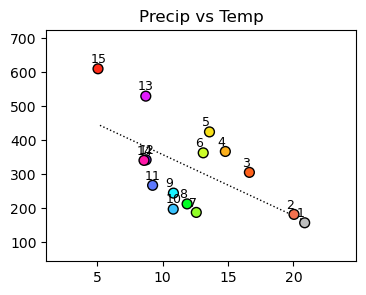

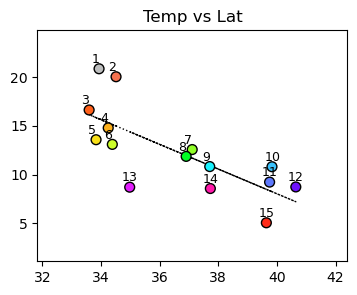

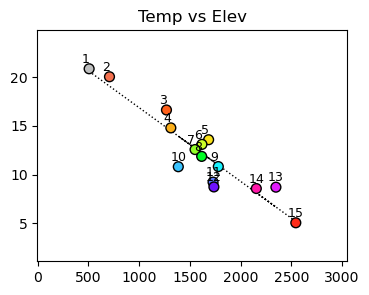

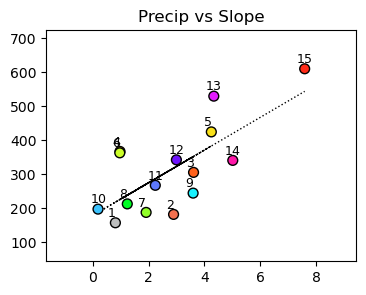

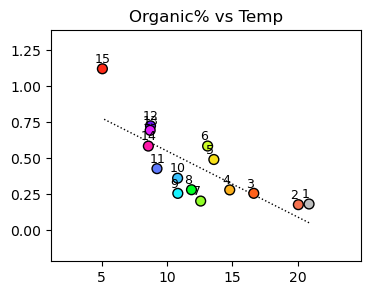

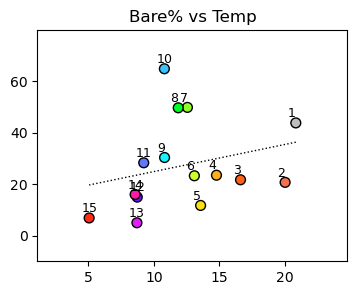

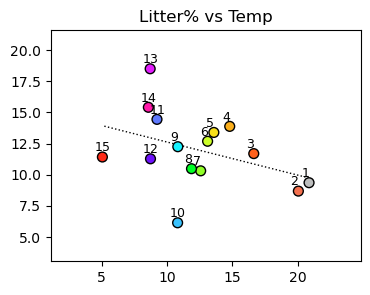

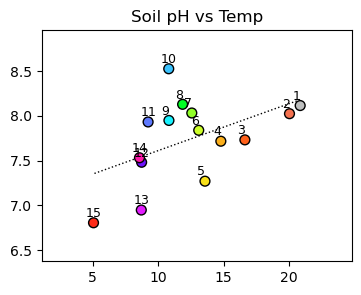

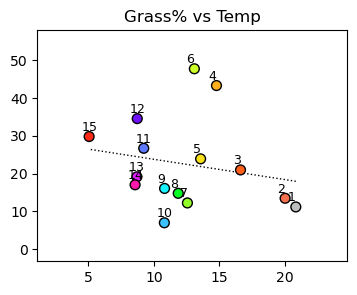

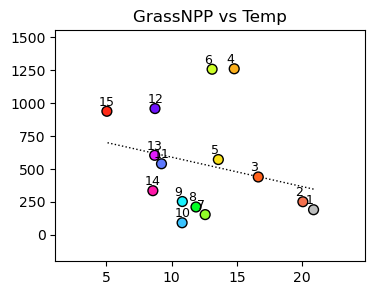

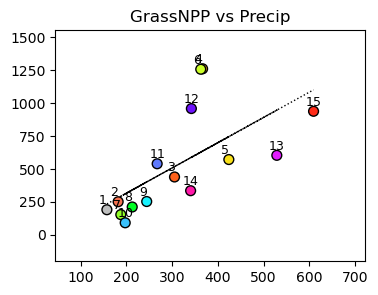

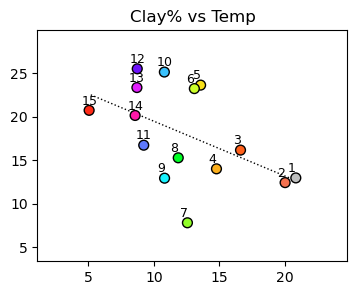

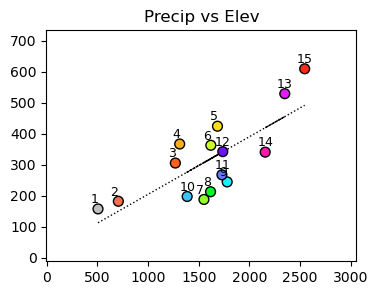

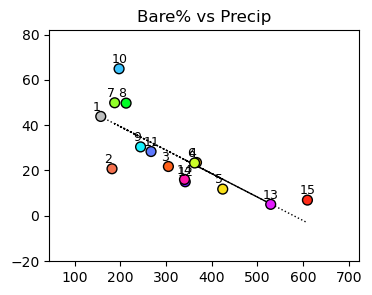

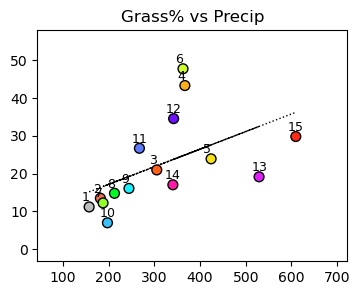

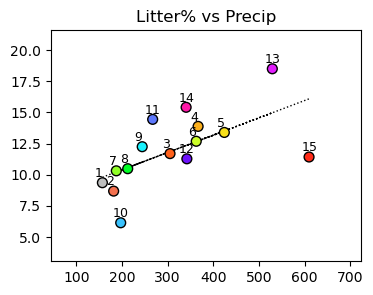

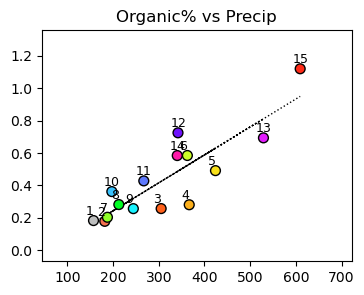

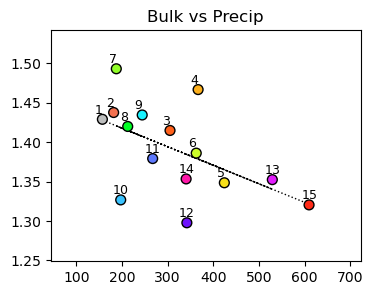

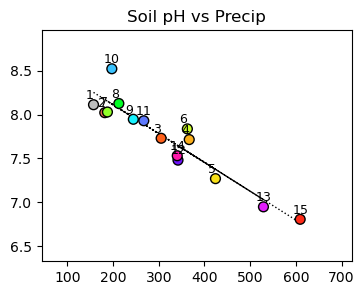

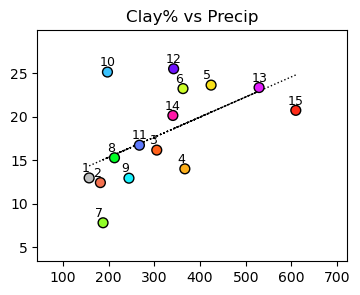

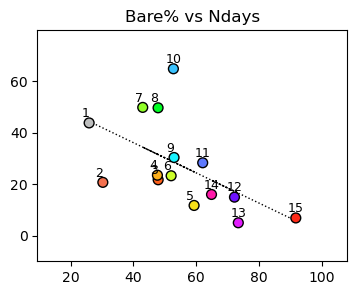

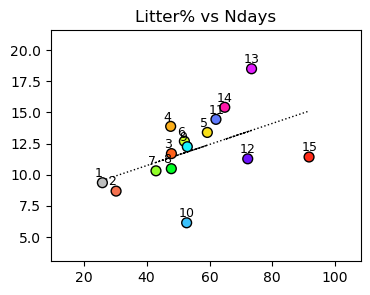

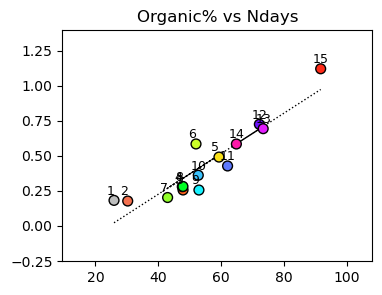

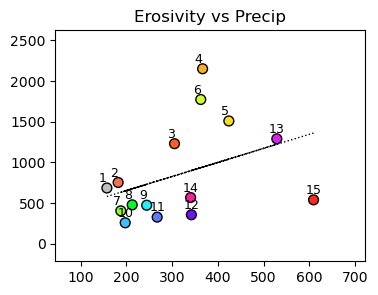

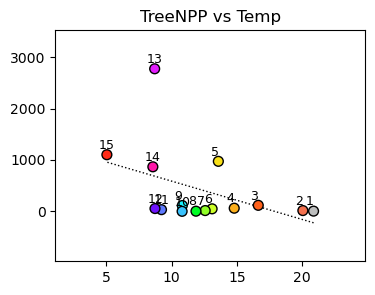

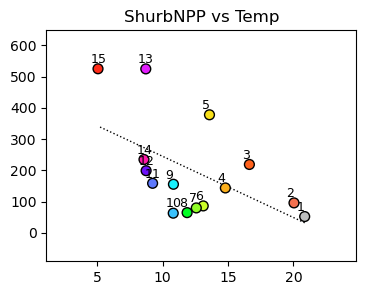

In [18]:
#ZONAL CORRELATION PLOTS

#########################################################################################

x = df['tavg']
y = df['accm']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Precip vs Temp')
plot_fn()

#########################################################################################

x = df['ylat']
y = df['tavg']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Temp vs Lat')
plot_fn()

#########################################################################################

x = df['elev']
y = df['tavg']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Temp vs Elev')
plot_fn()

#########################################################################################

x = df['slpe']
y = df['accm']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Precip vs Slope')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['orgm']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Organic% vs Temp')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['bare']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Bare% vs Temp')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['litr']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Litter% vs Temp')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['pphh']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Soil pH vs Temp')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['gras']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Grass% vs Temp')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['graN']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('GrassNPP vs Temp')
plot_fn()

#########################################################################################

x = df['accm']
y = df['graN']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('GrassNPP vs Precip')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['clay']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Clay% vs Temp')
plot_fn()

#########################################################################################

x = df['elev']
y = df['accm']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Precip vs Elev')
plot_fn()

#########################################################################################

x = df['accm']
y = df['bare']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Bare% vs Precip')
plot_fn()

#########################################################################################

x = df['accm']
y = df['gras']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Grass% vs Precip')
plot_fn()

#########################################################################################

x = df['accm']
y = df['litr']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Litter% vs Precip')
plot_fn()

#########################################################################################

x = df['accm']
y = df['orgm']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Organic% vs Precip')
plot_fn()

#########################################################################################

x = df['accm']
y = df['bulk']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Bulk vs Precip')
plot_fn()

#########################################################################################

x = df['accm']
y = df['pphh']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Soil pH vs Precip')
plot_fn()

#########################################################################################

x = df['accm']
y = df['clay']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Clay% vs Precip')
plot_fn()

#########################################################################################

x = df['nday']
y = df['bare']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Bare% vs Ndays')
plot_fn()

#########################################################################################

x = df['nday']
y = df['litr']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Litter% vs Ndays')
plot_fn()

#########################################################################################

x = df['nday']
y = df['orgm']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Organic% vs Ndays')
plot_fn()

#########################################################################################

x = df['accm']
y = df['eroR']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('Erosivity vs Precip')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['tree']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('TreeNPP vs Temp')
plot_fn()

#########################################################################################

x = df['tavg']
y = df['shrN']
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title('ShurbNPP vs Temp')
plot_fn()



### Itemized list of % area of ecoregions in iso classes.

In [14]:

import pandas as pd

arcpy.env.workspace = gdbDIR

arcpy.conversion.ExportTable(
  in_table='us_eco_l3_clip',
  out_table=os.path.join(projDIR, 'us_eco_l3_clip.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

arcpy.conversion.ExportTable(
  in_table='us_eco_l4_clip',
  out_table=os.path.join(projDIR, 'us_eco_l4_clip.csv'),
  where_clause='',
  use_field_alias_as_name='NOT_USE_ALIAS',
  sort_field=None
)

df = pd.read_csv(os.path.join(projDIR, 'Zonal', 'Zonal_eco3.csv'))
total_n = df.iloc[:, 1:].sum().sum()
eco_df = pd.read_csv(os.path.join(projDIR, 'us_eco_l3_clip.csv'))
ecoid_econame_key = dict(zip(eco_df['US_L3CODE'].tolist(), eco_df['US_L3NAME'].tolist()))
for i, row in df.iterrows():
  print('Class Num: ', i+1)
  row_n = row[1:].sum()
  sorted_row = row[1:].sort_values(ascending=False)
  top_three = sorted_row[:3].divide(row_n).multiply(100.0)
  top_index = top_three.index
  for j, eco_id in enumerate(top_index):
    print(top_three[j], ecoid_econame_key[int(eco_id.split('_')[-1])])
    pass

df = pd.read_csv(os.path.join(projDIR, 'Zonal', 'Zonal_eco4.csv'))
total_n = df.iloc[:, 1:].sum().sum()
eco_df = pd.read_csv(os.path.join(projDIR, 'us_eco_l4_clip.csv'))
ecoid_econame_key = dict(zip(eco_df['US_L4CODE'].tolist(), eco_df['US_L4NAME'].tolist()))
for i, row in df.iterrows():
  #print('Class Num: ', i+1)
  row_n = row[1:].sum()
  sorted_row = row[1:].sort_values(ascending=False)
  top_five = sorted_row[:5].divide(row_n).multiply(100.0)
  top_index = top_five.index
  for j, eco_id in enumerate(top_index):
    #print(top_five[j], ecoid_econame_key[eco_id.split('_')[-1]])
    pass


Class Num:  1
66.80467632734292 Sonoran Basin and Range
33.02431170181912 Mojave Basin and Range
0.09100637044593123 Chihuahuan Deserts
Class Num:  2
71.84534088105842 Sonoran Basin and Range
17.843185624699757 Mojave Basin and Range
4.274158995598603 Madrean Archipelago
Class Num:  3
41.680760298869146 Chihuahuan Deserts
26.328377423263326 Arizona/New Mexico Plateau
14.31239903069467 Madrean Archipelago
Class Num:  4
69.25612808008214 Central Basin and Range
17.635074435318277 Colorado Plateaus
7.855813655030801 Mojave Basin and Range
Class Num:  5
46.29496983869495 Central Basin and Range
31.052450474364647 Arizona/New Mexico Plateau
15.304667804299127 Colorado Plateaus
Class Num:  6
31.24391895573389 Arizona/New Mexico Plateau
25.28780366302647 Central Basin and Range
20.82149556716197 Colorado Plateaus
Class Num:  7
50.312384046852586 Central Basin and Range
35.88455328579881 Northern Basin and Range
5.561739723417271 Colorado Plateaus
Class Num:  8
45.466376127353065 Central Basin

C:\Users\fullh\AppData\Local\Temp\ipykernel_36996\3423522940.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(top_three[j], ecoid_econame_key[int(eco_id.split('_')[-1])])


### Plot PCA loading

{1: 'accm_1974_2013', 2: 'CCSM4_1974_2013_ero', 3: 'CCSM4_1974_2013_ndays', 4: 'DEM_Elev', 5: 'DEM_Slope', 6: 'POL_bd', 7: 'POL_ksat', 8: 'POL_om', 9: 'POL_ph', 10: 'POL_sand', 11: 'RAP_afgNPP', 12: 'RAP_bgr', 13: 'RAP_ltr', 14: 'RAP_pfgNPP', 15: 'RAP_shrNPP', 16: 'RAP_treNPP', 17: 'tmomn_1974_2013'}


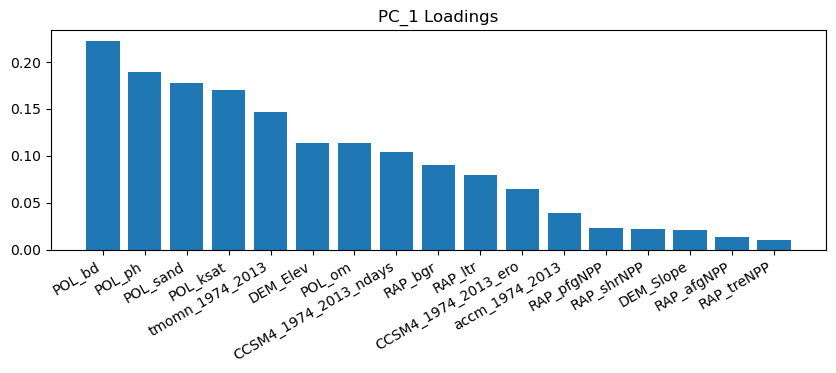

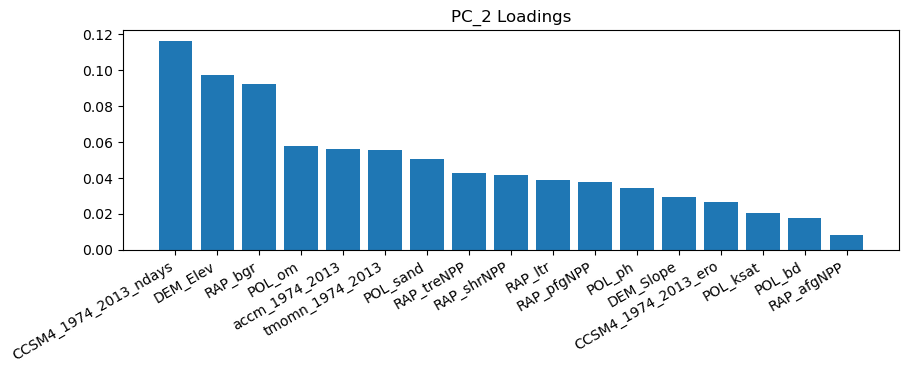

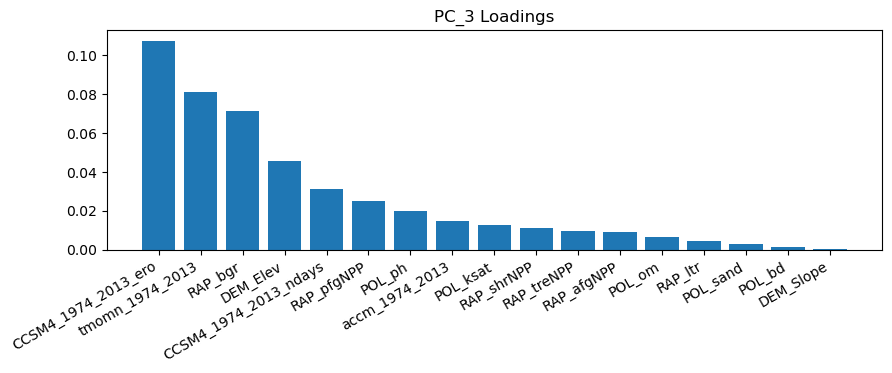

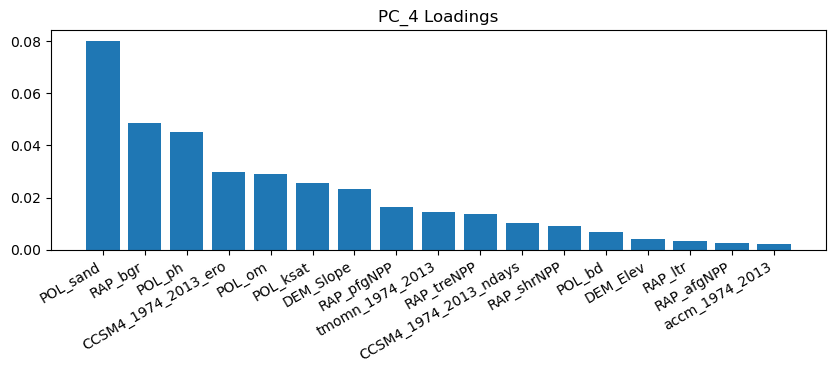

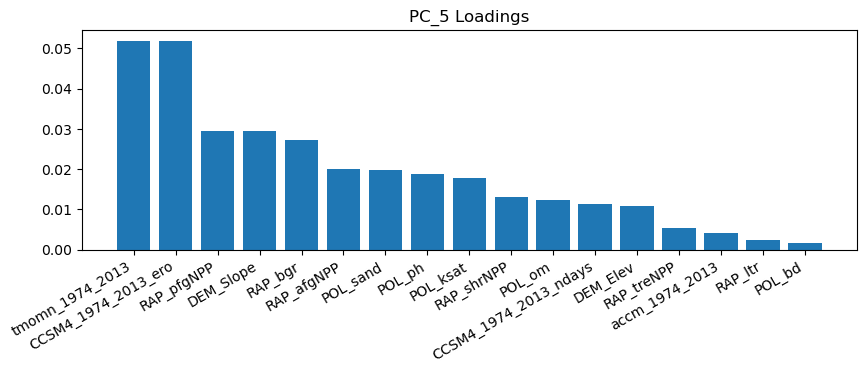

In [21]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

df = pd.read_csv(os.path.join(projDIR, 'MultidimRasterLyr_d_loading.csv'))

print(varidx_varlbl_key)

for i in range(1, 6):
  col_str = 'PC_{}'.format(i)
  sorted_df = df.sort_values(by=col_str, key=abs, ascending=False)
  sorted_idx = [x+1 for x in sorted_df.index.to_list()]
  x_labels = [varidx_varlbl_key[sorted_idx[j]] for j in range(len(sorted_idx))]
  y = sorted_df[col_str].to_list()
  y_abs = [abs(n) for n in y]
  fig, ax = plt.subplots(figsize=(8.5, 3))
  ax.tick_params(axis='x', labelrotation=45)
  fig.tight_layout()
  fig.autofmt_xdate()
  ax.set_title('PC_{} '.format(i) + 'Loadings')
  ax.bar(x_labels, y_abs)
  

### Create dendrogram

In [29]:

arcpy.env.workspace = projDIR

arcpy.sa.Dendrogram(
  in_signature_file='iso_signature.gsg', 
  out_dendrogram_file='dendro.txt', 
  distance_calculation='VARIANCE', 
  line_width=''
)


<Result 'C:\\Users\\fullh\\Documents\\ArcGIS\\Projects\\MyProject\\dendro.txt'>

### Train ISO Cluster Classification Tool, outputs a ecd definition file.

In [16]:

arcpy.env.workspace = gdbDIR

arcpy.sa.TrainIsoClusterClassifier(
  in_raster='Extract_Composite',
  max_classes='15',
  out_classifier_definition=os.path.join(projDIR, 'definitions.ecd'),
  min_samples_per_cluster=250,
  used_attributes='COLOR;MEAN;STD;COUNT;COMPACTNESS;RECTANGULARITY'
)
    

<Result 'C:\\Users\\fullh\\Documents\\ArcGIS\\Projects\\MyProject\\definitions.ecd'>

### Iso Cluster with test cluster numbers

In [5]:

if not os.path.exists(os.path.join(projDIR, 'IsoCluster_Test')):
  os.makedirs(os.path.join(projDIR, 'IsoCluster_Test'))

arcpy.env.workspace = gdbDIR

test_cluster_sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
for n in test_cluster_sizes:

  print(n)
    
  with arcpy.EnvManager(scratchWorkspace=os.path.join(gdbDIR)):
    output_classified_raster = arcpy.sa.IsoClusterUnsupervisedClassification(
      in_raster_bands='Extract_Composite',
      Number_of_classes=n,
      Minimum_class_size=250,
      Sample_interval=5,
      out_signature_file=os.path.join(projDIR, 'iso_signature.gsg')
    )
  output_classified_raster.save('FloatIsoCluster')

  with arcpy.EnvManager(scratchWorkspace=gdbDIR):
    out_raster = arcpy.ia.Int(
      in_raster_or_constant='FloatIsoCluster'
    )
  out_raster.save('IsoCluster')

  arcpy.CopyRaster_management('IsoCluster', os.path.join(projDIR, 'IsoCluster_Test', 'IsoCluster_{}.tif'.format(n)))

print('DONE')


3
6
9
12
15
18
21
24
27
30
DONE


### Iso Cluster PCA with test cluster numbers

In [23]:
import random

if not os.path.exists(os.path.join(projDIR, 'IsoCluster_Test')):
  os.makedirs(os.path.join(projDIR, 'IsoCluster_Test'))

arcpy.env.workspace = gdbDIR

test_cluster_sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
for n in test_cluster_sizes:

  print(n)
    
  threedigits = [str(x) for x in random.sample(range(0, 10), 3)]

  arcpy.md.RasterToNetCDF(
    in_raster='Extract_Composite',
    out_netCDF_file=os.path.join(projDIR, 'RasterToNetCD' + ''.join(threedigits) + '.nc'),
    variable='Extract_Composite',
    variable_units='',
    x_dimension='lon',
    y_dimension='lat',
    band_dimension='band',
    fields_to_dimensions=None,
    compression_level=0
  )

  arcpy.md.MakeMultidimensionalRasterLayer(
    in_multidimensional_raster=os.path.join(projDIR, 'RasterToNetCD' + ''.join(threedigits) + '.nc'),
    out_multidimensional_raster_layer='MultidimRasterLyr',
    variables='Extract_Composite',
    dimension_def='ALL',
    dimension_ranges=None,
    dimension_values=None,
    dimension='',
    start_of_first_iteration='',
    end_of_first_iteration='',
    iteration_step=None,
    iteration_unit='',
    template='-120.00833328533 31.3333333207995 -102.991666625469 42.00833331653 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]',
    dimensionless='DIMENSIONS',
    spatial_reference=None
  )
    
  arcpy.ia.MultidimensionalPrincipalComponents(
    in_multidimensional_raster='MultidimRasterLyr',
    mode='DIMENSION_REDUCTION',
    dimension='band',
    out_pc=os.path.join(projDIR, 'MultidimRasterLyr_d_pc.crf'),
    out_loadings=os.path.join(projDIR, 'MultidimRasterLyr_d_loading.csv'),
    out_eigenvalues=os.path.join(gdbDIR, 'eigenvalues'),
    variable='Extract_Composite',
    number_of_pc='99%'
  )

  with arcpy.EnvManager(scratchWorkspace=gdbDIR):
    Output_classified_raster = arcpy.sa.IsoClusterUnsupervisedClassification(
      in_raster_bands=os.path.join(projDIR, 'MultidimRasterLyr_d_pc.crf'),
      Number_of_classes=n,
      Minimum_class_size=250,
      Sample_interval=5,
      out_signature_file=os.path.join(projDIR, 'iso_signature.gsg')
    )
  Output_classified_raster.save(os.path.join(gdbDIR, 'IsoCluster'))

  arcpy.CopyRaster_management('IsoCluster', os.path.join(projDIR, 'IsoCluster_Test', 'IsoCluster_{}.tif'.format(n)))

print('DONE')


3
6
9
12
15
18
21
24
27
30
DONE


### Zonal stats for ecoregion level 3 for test cluster numbers

In [24]:

if not os.path.exists(os.path.join(projDIR, 'Zonal_Test')):
  os.makedirs(os.path.join(projDIR, 'Zonal_Test'))

arcpy.env.workspace = gdbDIR

test_cluster_sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]

for n in test_cluster_sizes:

  print(n)
    
  arcpy.sa.ZonalHistogram(
    in_zone_data='us_eco_l3_clip',
    zone_field='US_L3CODE',
    in_value_raster=os.path.join(projDIR, 'IsoCluster_Test', 'IsoCluster_{}.tif'.format(n)),
    out_table='Zonal_eco3_{}'.format(n),
    out_graph='',
    zones_as_rows='ZONES_AS_FIELDS'
  )

  arcpy.conversion.ExportTable(
    in_table='Zonal_eco3_{}'.format(n),
    out_table=os.path.join(projDIR, 'Zonal_Test', 'Zonal_eco3_{}.csv'.format(n)),
    where_clause='',
    use_field_alias_as_name='NOT_USE_ALIAS',
    sort_field=None
  )

  arcpy.management.Delete('Zonal_eco3_{}'.format(n))

print('DONE')


3
6
9
12
15
18
21
24
27
30
DONE
